In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

In [2]:
rs = 1729

In [3]:
original_df = pd.read_csv(r'../datasets/aug_train.csv')
original_df = original_df.loc[:, ~original_df.columns.isin(['id'])]
original_df.head()


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


In [4]:
def to_numpy(df, preds, trgts, encs=None):
    columns = list(df.columns)
    X = np.empty(df[[i for k, v in preds.items() for i in v]].shape)
    Y = np.empty(df[[i for k, v in trgts.items() for i in v]].shape)

    for i, col in enumerate(preds['continuous']):
        X[:, columns.index(col)] = df[col]
    for i, col in enumerate(trgts['continuous']):
        Y[:, i] = df[col]

    if encs is None:
        encs = dict()
    for i, col in enumerate(preds['categorical']):
        if col not in encs:
            enc = LabelEncoder()
            enc.fit(df[col])
            encs[col] = enc
        else:
            enc = encs[col]
        X[:, columns.index(col)] = enc.transform(df[col])
    for i, col in enumerate(trgts['categorical']):
        if col not in encs:
            enc = LabelEncoder()
            enc.fit(df[col])
            encs[col] = enc
        else:
            enc = encs[col]
        Y[:, i] = enc.transform(df[col])

    return X, Y, encs


In [5]:
import joblib


predictors = {'categorical': ['Gender', 'Age', 'Driving_License',
                                  'Region_Code', 'Previously_Insured', 'Vehicle_Age',
                                  'Vehicle_Damage', 'Policy_Sales_Channel', 'Vintage'],
              'continuous': ['Annual_Premium']}
targets = {'categorical': ['Response'],
           'continuous': []}
pre_process_model = joblib.load(r"../model/logistic_regression_pre_process.pkl")
original_df = original_df[pre_process_model['columns']]
_X, _Y, _encs = to_numpy(original_df,
                         preds=predictors,
                         trgts=targets,
                         encs=pre_process_model["encs"])
joined = np.hstack((_X, _Y))

/Users/Vishvig/Desktop/Education/UoB/.uob/envs/data_analytics/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
n_samples, n_features = original_df.shape

features = list()
features.extend(predictors['categorical'])
features.extend(targets['categorical'])

X = np.zeros((n_samples, len(features)))
columns = list(pre_process_model['columns'])

for i, feature in enumerate(features):
    X[:, i] = joined[:, columns.index(feature)]
print(X[0:20])
X = X[0:10000]

[[  1.   2.   1.   7.   1.   1.   0. 146.   6.   0.]
 [  1.  22.   1.  28.   0.   0.   1.  24. 125.   0.]
 [  0.  46.   1.  33.   0.   0.   1. 119. 243.   0.]
 [  0.   2.   1.  33.   0.   1.   0. 146.  59.   0.]
 [  1.   8.   1.  46.   1.   1.   0. 146. 201.   0.]
 [  0.   5.   1.  25.   1.   1.   0. 146.  13.   0.]
 [  1.  31.   1.   8.   0.   0.   1.  24. 199.   0.]
 [  1.  18.   1.  28.   1.   0.   0.  24.  41.   0.]
 [  0.  25.   1.  28.   0.   0.   1. 119. 252.   0.]
 [  1.  22.   1.  28.   0.   0.   1. 117. 207.   1.]
 [  1.   5.   1.   8.   1.   1.   0. 146.  63.   0.]
 [  0.   6.   1.   8.   1.   1.   0. 146.   2.   0.]
 [  1.  13.   1.  28.   0.   1.   1. 117. 155.   1.]
 [  1.   5.   1.  28.   1.   1.   0. 146.  24.   0.]
 [  1.  22.   1.  28.   0.   0.   1. 119. 253.   1.]
 [  1.  25.   1.  41.   0.   0.   1.  24. 145.   1.]
 [  0.  56.   1.  28.   0.   2.   0. 152. 141.   0.]
 [  1.   3.   1.  28.   1.   1.   0. 146. 166.   0.]
 [  1.  29.   1.  28.   0.   0.   1.  24. 167.

In [14]:
from mnmm import MNMM

model = MNMM(n_components=4,
             random_state = 1729,
             max_iter=10,
             rtol=1e-3)
model.fit(X)
print(model.alpha)

[array([0.14646006, 0.25102622, 0.22633065, 0.37618307]), array([0.05727625, 0.34162036, 0.24262204, 0.35848136]), array([0.1438775 , 0.46845686, 0.33328421, 0.05438143]), array([0.03031333, 0.36843434, 0.28425282, 0.31699951]), array([0.08022573, 0.10692369, 0.38686628, 0.42598431]), array([0.48481169, 0.16491853, 0.104289  , 0.24598078]), array([0.21796423, 0.40854446, 0.05289353, 0.32059778]), array([0.07511683, 0.37248568, 0.42524698, 0.12715052]), array([0.31115556, 0.22200934, 0.42238574, 0.04444936]), array([0.36277427, 0.36231836, 0.09509484, 0.17981252])]


In [11]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import KFold


def cross_validation(model, X, cv=5):
    train_scores = list()
    val_scores = list()
    _cv = KFold(n_splits=cv,random_state=rs, shuffle=True)
    with warnings.catch_warnings():
        warnings.filterwarnings('error', category=ConvergenceWarning)
        try:
            for train_index, val_index in _cv.split(X):
                Xtrain, Xval = X[train_index], X[val_index]
                model.fit(Xtrain)
                train_score = model.score_samples(Xtrain)
                val_score = model.score_samples(Xval)
#                 print(f'%%%%{train_score}, {val_score}')
                train_scores.append(np.sum(train_score))
                val_scores.append(np.sum(val_score))
        except ValueError as e:
            raise ValueError(e)
        except ConvergenceWarning as e:
            raise ConvergenceWarning(e)
        except Exception as e:
            raise Exception(e)
    return {'train_score': train_scores, 'test_score': val_scores}


def train(X, **kwargs):
    trainNLL = []
    validNLL = []
    nvalid = []
    valid_max_iter = None
    valid_tol = None
    
    max_iters = kwargs.get('max_iters', None)
    tols = kwargs.get('tols', None)
    nvals = kwargs.get('nvals', None)
    
    if max_iters is None:
        max_iters = [10, 100, 1000, 10000, 100000]
    if tols is None:
        tols = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    if nvals is None:
        nvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40 , 50]
    
    with warnings.catch_warnings():
        warnings.filterwarnings('error', category=ConvergenceWarning)
        for tol in tols:
            if valid_tol is None:
                valid_tol = tol
            else:
                print(f"valid tol from training: {valid_tol}")
                break
            print(f"Trying tol: {tol}")
            for max_iter in max_iters:
                if valid_max_iter is None:
                    valid_max_iter = max_iter
                else:
                    if valid_tol is None:
                        continue
                    if len(nvalid) > 0:
                        print(f"valid max_iter from training: {valid_max_iter}")
                        break
                print(f"Trying max_iter: {max_iter}")
                for j, n in enumerate(nvals):
                    if valid_max_iter is None or valid_tol is None:
                        break
                    print(f"{j}")
                    train_score = None
                    validation_score = None
                    try:
                        model = MNMM(n_components=n,
                                     random_state = rs,
                                     max_iter=valid_max_iter,
                                     rtol=valid_tol)
                        scores = cross_validation(model, X, cv=5)
                        print(f"&&&&& {scores}")
                        trainNLL.append(np.mean(scores['train_score']))
                        validNLL.append(np.mean(scores['test_score']))
                        nvalid.append(f"{j}")
                    except Exception as e:
                        print(e)
                        break
#                     except ValueError as e:
#                         warnings.warn(f"reg_covar {reg_covar} is too small.")
#                         valid_reg_covar = None
#                         valid_max_iter = None
#                         trainNLL = []
#                         validNLL = []
#                         nvalid = []
#                         break
#                     except ConvergenceWarning:
#                         warnings.warn(f"max_iter {max_iter} is too small to reach convergence.")
#                         valid_max_iter = None
#                         trainNLL = []
#                         validNLL = []
#                         nvalid = []
#                         break
    return trainNLL, validNLL, nvalid, valid_max_iter, valid_tol



# hyperparams = dict(max_iters=[10, 100, 1000, 10000, 100000],
#                    reg_covars=[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
#                    nvals=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40 , 50),
#                    cov_types=['full', 'spherical', 'diag', 'tied'])
_trainNLL, _validNLL, _nvalid, _valid_max_iter, _valid_tol = train(X)

Trying tol: 1e-06
Trying max_iter: 10
0
&&&&& {'train_score': [0.15373551927171952, 0.08356000331472008, 0.10772359744983122, 0.08716687013246233, 0.1346382662304222], 'test_score': [0.09811982507967756, 0.2936062147214907, 0.29230363264301085, 0.2754013333289694, 0.15243063899598538]}
1
&&&&& {'train_score': [0.22257366450073202, 0.28074600831168567, 0.3134342335423694, 0.3030896279924714, 0.35254176596288], 'test_score': [0.41948019358251476, 0.6220976776067272, 0.7293928439023941, 0.5876482264178245, 0.544230205949346]}
2
&&&&& {'train_score': [0.33915749274934076, 0.36512589946315194, 0.37631067365663423, 0.30769125637477385, 0.3772989029904614], 'test_score': [0.44359306374068785, 0.7788485241757561, 0.713887983315247, 0.7754304460776971, 0.7607478146048823]}
3
&&&&& {'train_score': [0.3675062956977295, 0.48386289066846405, 0.4146877951916103, 0.4645038301776721, 0.283616046403024], 'test_score': [0.8386726403478582, 0.9235613587698844, 1.0477499782510016, 1.0972652501952906, 0.79

Text(0.5, 1.0, 'Elbow Method For Optimal n')

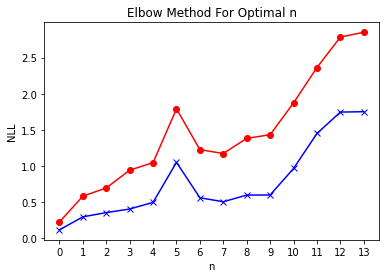

In [12]:
#Create elbow plot

# fig,ax = plt.subplots(2, 2, figsize=(15,15))


# for i, cov_type in enumerate(cov_types):
#     row_num = int(i/2)
#     col_num = i%2
#     if len(ax.shape) > 1:
#         line1 = ax[row_num, col_num].plot(nvals, trainNLL[(0 + (i * 14)):(14 + (i * 14))], 'bx-')
#         line2 = ax[row_num, col_num].plot(nvals, validNLL[(0 + (i * 14)):(14 + (i * 14))], 'ro-')
#         ax[row_num, col_num].set_xlabel('K')
#         ax[row_num, col_num].set_ylabel('NLL')
#         ax[row_num, col_num].title.set_text(cov_type.upper())
#         ax[row_num, col_num].legend(['training', 'validation'])
#     else:
#         line1 = ax[col_num].plot(nvals, trainNLL[(0 + (i * 14)):(14 + (i * 14))], 'bx-')
#         line2 = ax[col_num].plot(nvals, validNLL[(0 + (i * 14)):(14 + (i * 14))], 'ro-')
#         ax[col_num].set_xlabel('K')
#         ax[col_num].set_ylabel('NLL')
#         ax[col_num].title.set_text(cov_type.upper())
#         ax[col_num].legend(['training', 'validation'])

plt.figure(0)
plt.plot(_nvalid, _trainNLL, 'bx-')
plt.plot(_nvalid, _validNLL, 'ro-')
plt.xlabel('n')
plt.ylabel('NLL')
plt.title('Elbow Method For Optimal n')

In [ ]:
min_bic_index = validateAIC.index(min(validateAIC))
hyperparams = nvalid[min_bic_index].split('-')
cov_type = cov_types[int(hyperparams[0])]
components = nvals[int(hyperparams[1])]
print(cov_type, components)

In [ ]:
model = GaussianMixture(n_components=components, covariance_type=cov_type, random_state = 1729, max_iter=1000, reg_covar=1e-4)
model.fit(X)
print(X.shape)
Xn = model.sample(382154)


In [ ]:
model.converged_

In [ ]:
# plotting the distribution of the features using histogram

fig_rows = int(n_features/2) if n_features % 2 == 0 else int(n_features/2 + 1)
fig_columns = 2
bins = 50

fig,ax = plt.subplots(fig_rows, fig_columns, figsize=(15,15))
for feature in range(n_features):
    row_num = int(feature/fig_columns)
    col_num = feature%fig_columns
    if len(ax.shape) > 1:
        ax[row_num, col_num].hist([X[:, feature], Xn[0][:, feature]],
                                  bins=bins,
                                  label=['original', 'synthetic'])
        ax[row_num, col_num].legend(['original', 'synthetic'])

    else:
        ax[col_num].hist([X[:, feature], Xn[0][:, feature]],
                         bins=bins, 
                         label=['original', 'synthetic'])
        ax[col_num].legend(['original', 'synthetic'])


In [ ]:
from scipy.stats import ks_2samp

n_samples, n_features = X.shape

for col in range(n_features):
    pvalue = ks_2samp(data1=X[:, col], data2=Xn[0][:, col], alternative='two-sided')
    print(pvalue)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

n0, bins0, patches0 = ax.hist(X[:, 0],
                              bins=100,
                              histtype='step',
                              cumulative=True,
                              label='Original')
n1, bins1, patches1 = ax.hist(Xn[0][:, 0],
                              bins=bins,
                              histtype='step',
                              cumulative=True,
                              label='Synthetic')
ax.grid(True)
ax.legend(loc='lower center')